1. Load data

In [1]:
import os
import numpy as np
# set names to the paths because they're too long
data_path = 'C:\\Users\\Admin\\Downloads'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [2]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
  """
  This shuffle param is active when .gz is downloaded at:
  - 'http://yann.lecun.com/exdb/mnist/'
  - This function return random num_images in 60000 or 10000
  """
  # read data
  import gzip # to decompress gz (zip) file
  # open file training to read training data
  f_images = gzip.open(images_path,'r')
  # skip 16 first bytes because these are not data, only header infor
  f_images.read(16)
  # general: read num_images data samples if this parameter is set;
  # if not, read all (60000 training or 10000 test)
  real_num = num_images if not shuffle else (60000 if _is else 10000)
  # read all data to buf_images (28x28xreal_num)
  buf_images = f_images.read(image_size * image_size * real_num)
  # images
  images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
  images = images.reshape(real_num, image_size, image_size,)
  # Read labels
  f_labels = gzip.open(labels_path,'r')
  f_labels.read(8)
  labels = np.zeros((real_num)).astype(np.int64)
  # rearrange to correspond the images and labels
  for i in range(0, real_num):
    buf_labels = f_labels.read(1)
    labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
  # shuffle to get random images data
  if shuffle is True:
    rand_id = np.random.randint(real_num, size=num_images)
    images = images[rand_id, :]
    labels = labels[rand_id,]
  # change images data to type of vector 28x28 dimentional
  images = images.reshape(num_images, image_size * image_size)
  return images, labels

In [3]:
# chia train test
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000, shuffle=False)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=False)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1376\361972391.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(60000, 784) (60000,)
(10000, 784) (10000,)


2. Build Model

In [4]:
# Áp dụng chuẩn hóa cho cả dữ liệu train và test
train_images = train_images / 255
test_images = test_images / 255

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình GaussianNB
model = GaussianNB()

# Huấn luyện mô hình
model.fit(train_images, train_labels)

# Dự đoán nhãn của dữ liệu kiểm tra
predicted_labels = model.predict(test_images)

3. Result

3.1. Accuracy

In [6]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.5558


3.2. Confusion matrix

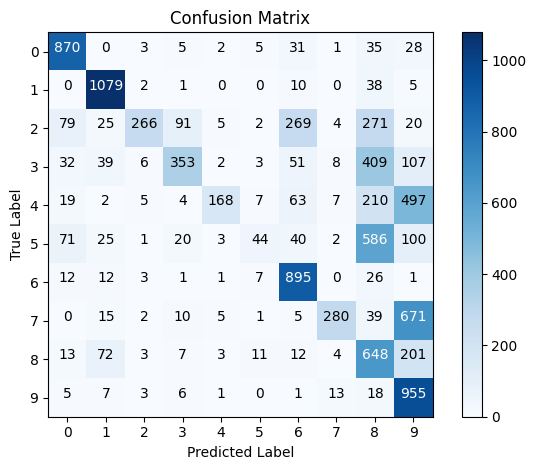

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
# Tính confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Vẽ biểu đồ confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

3.3. Recall and Precision

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
print("Recall:", recall)
print("Precision:", precision)

Recall: 0.548447051043586
Precision: 0.6864966027174797


4. Build another Naive Bayes model

In [9]:
import numpy as np

class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.means = np.zeros((len(self.classes), X.shape[1]))
        self.variances = np.zeros((len(self.classes), X.shape[1]))

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / len(X)
            self.means[i] = np.mean(X_c, axis=0)
            self.variances[i] = np.var(X_c, axis=0) + 1e-9  # Thêm giá trị nhỏ để tránh phép chia cho 0

    def predict(self, X):
        predictions = []
        for x in X:
            likelihoods = []
            for i in range(len(self.classes)):
                prior = np.log(self.class_priors[i])
                likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.variances[i]))
                likelihood -= 0.5 * np.sum(((x - self.means[i]) ** 2) / self.variances[i])
                likelihoods.append(prior + likelihood)
            predictions.append(self.classes[np.argmax(likelihoods)])
        return predictions

In [10]:
# Xây dựng và huấn luyện mô hình Gaussian Naive Bayes
model = GaussianNaiveBayes()
model.fit(train_images, train_labels)

# Dự đoán và đánh giá hiệu suất
predictions = model.predict(test_images)

5. Result

5.1. Accuracy

In [11]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5678


5.2. Confusion matrix

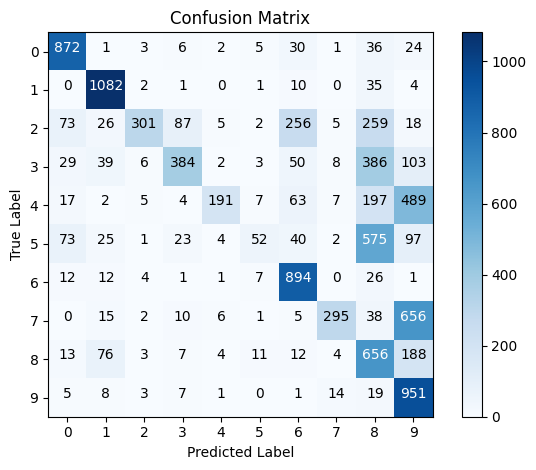

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
# Tính confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Vẽ biểu đồ confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

5.3 Recall and Precision

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
print("Recall:", recall)
print("Precision:", precision)

Recall: 0.560394932462182
Precision: 0.6948775609829168


6. Predict with test dataset

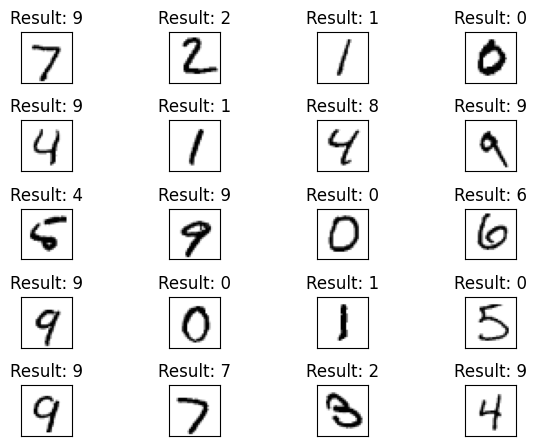

In [18]:

for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i].reshape(28, 28), cmap='binary')  # Hiển thị ảnh grayscale
    plt.title(f"Result: {predictions[i]}")  # Nhãn dự đoán
plt.show()

7. Predict with the data we collect ourselves

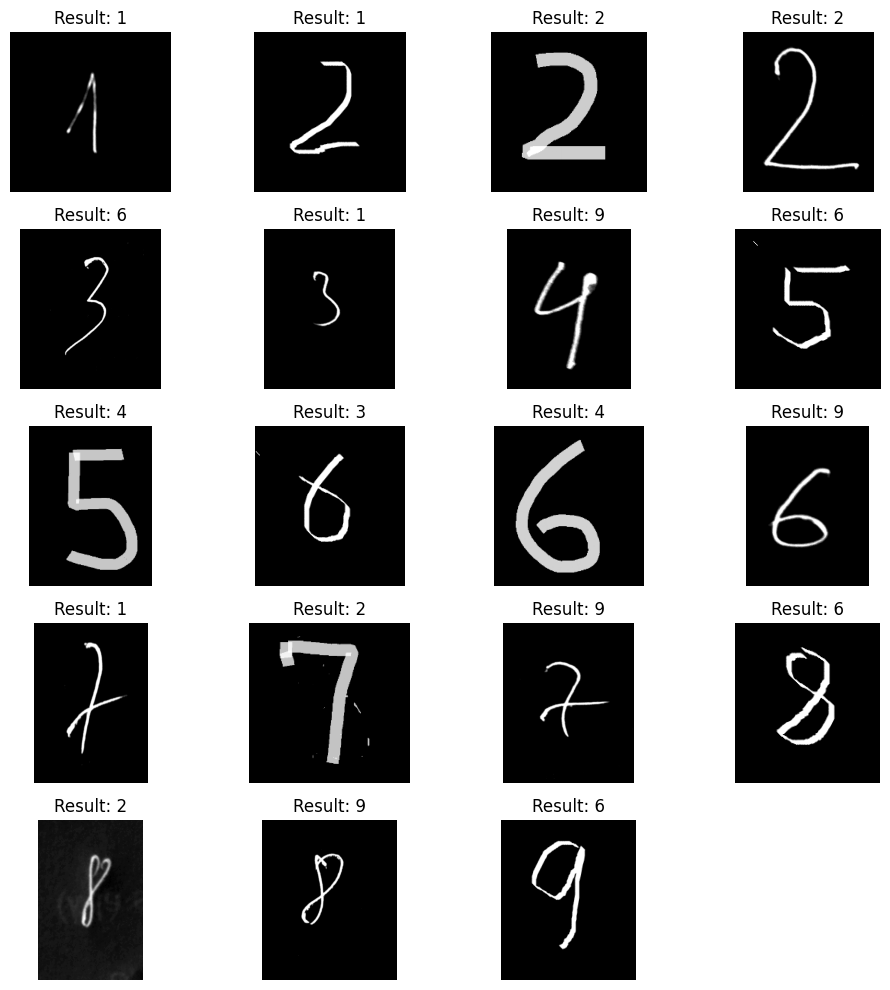

In [15]:
import os
import numpy as np
import cv2
from PIL import Image

model = GaussianNaiveBayes()
model.fit(train_images, train_labels)
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

folder_path = r"data_real"

fig = plt.figure(figsize=(10, 10))

for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(folder_path, filename)
        frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        im = Image.fromarray(frame)
        im = im.resize((28, 28))
        
        img_array = np.array(im)
        img_array = img_array.reshape(1, 784)  # chuyển về (1, 784) để khớp với kích thước của train_images
        predict = model.predict(1.0-img_array)
        ax = fig.add_subplot(5, 4, i+1)
        ax.imshow(frame, cmap='binary')
        ax.set_title('Result: ' + str(predict[0]))
        ax.axis('off')
    else:
        continue

plt.tight_layout()
plt.show()